# PLS Regression
I'm following this paper: <https://www.sciencedirect.com/science/article/pii/S1878929316301074?via%3Dihub>

In [1]:
import glob
import os

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

## Get Data

In [2]:
def get_subject_from_path(path):
    normalized_path = os.path.normpath(path)
    path_components = normalized_path.split(os.sep)
    return path_components[-2][4:]

In [3]:
# Search for all functional connectivity files and read them
fc_path = '/imaging3/owenlab/bpho/python_power_fc'
fc_paths = glob.glob(fc_path + '/**/power_fc.npy', recursive=True)

fcs = {}
for path in fc_paths:
    subject_id = get_subject_from_path(path)
    subject_fc = np.load(path)
    fcs[subject_id] = subject_fc[np.triu_indices(264, k=1)]
print("Number of functional connectivity:", len(fcs))
print("Number of features (connections):", fcs["NDARAP912JK3"].shape[0])

Number of functional connectivity: 825
Number of features (connections): 34716


## Get Labels

In [4]:
wisc_label_path = "/imaging3/owenlab/bpho/Biobank Labels/Subjects_with_WISC.csv"
wisc_labels = pd.read_csv(wisc_label_path, index_col='assessment WISC,EID')
# display(wisc_labels)

In [5]:
subject_ids = wisc_labels.index
measure_text = "WISC_Vocab_Scaled"
measure_col = f'assessment WISC,{measure_text}'
# measure_text = "Age"
# measure_col = 'assessment Basic_Demos,Age'

fc_matrices = []
measures = []

for subject_id in subject_ids:
    if subject_id not in fcs:
        continue
    
    fc_matrices.append(fcs[subject_id])
    measures.append(wisc_labels.at[subject_id, measure_col])
    
print("Num subjects with measures:", len(measures))

Num subjects with measures: 577


In [6]:
X = np.array(fc_matrices)
y = np.array(measures)

print("X shape:", X.shape, "y shape:", y.shape)

X shape: (577, 34716) y shape: (577,)


## Feature selection

In [7]:
from sklearn.feature_selection import VarianceThreshold

In [118]:
sel = VarianceThreshold(0.06)
X = sel.fit_transform(X)

print("X shape:", X.shape)

X shape: (577, 911)


## Train PLS Regression

### Set up PLSRW

In [ ]:
from numpy.linalg import inv

In [ ]:
class PLSRW():
    
    def __init(self, n_components=2, reg=0.01):
        self.n_components=n_components
        self.reg = reg
    
    def fit(self, X, Y):
        n_components = self.n_components
        reg = self.reg
        eps = np.finfo(X.dtype).eps
        x_curr = X
        
        for k in range(n_components):
            # Compute the regularization matrix
            
            # Compute the PLSRW weight
            w_inter = inv(x_curr.T @ x_curr) + (reg * (D.T @ D))
            w = (w_inter @ x_curr.T) @ y
            
            # Normalize weight
            w /= np.sqrt(np.dot(w, w)) + eps
            
            # Calculate the corresponding scores and loadings
            t = x_curr @ w
            p = (x_curr.T @ t) / (t.T @ t)
            q = (Y.T @ t) / (t.T @ t)
            
            # Deflate X
            x_curr = x_curr - (t @ p.T)
            
            # Compute transformation matrices
            x_rotations = np.dot(
                w, pinv2(np.dot(p.T, w),check_finite=False))
        
        self.coef_ = np.dot(x_rotations, q.T)
        return self
    
    def predict(self, X):
        Ypred = np.dot(X, self.coef_)
        return Ypred

### Determine optimal number of components

In [7]:
from scipy import stats
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score

In [11]:
num_component = 2
kf = KFold(n_splits=10)
train_scores = []
test_scores = []
num_iter = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pls = PLSRegression(n_components=num_component)
    pls.fit(X_train, y_train)
    
    train_scores.append(pls.score(X_train, y_train))
    test_scores.append(pls.score(X_test, y_test))
    num_iter.append(pls.n_iter_)

print("Avg train score:", np.mean(train_scores))
print("Avg test score:", np.mean(test_scores))
print("Avg iter:", np.mean(num_iter[0]))

1.470638401460223
1.7001631981483523
1.4751872077425277
1.7498058504513867
1.4734271961094465
1.6986655518427494
1.474017370650296
1.7176389924347326
1.4763849025017712
1.7054301173128747
1.4700109402315658
1.7549353862196642
1.4632606689789658
1.7595688105217897
1.4763582129111925
1.7525897290072172
1.464007438784648
1.7209348746572377
1.4768266817537787
1.6822064064484936
Avg train score: 0.35558538665182265
Avg test score: 0.05109907398500931
Avg iter: 2.0


### Use PLS to predict scores

0 0 r:0.26 r^2:-0.00
1 0 r:0.25 r^2:0.03
2 0 r:0.27 r^2:0.02
0 1 r:0.29 r^2:0.06
1 1 r:0.27 r^2:0.01
2 1 r:0.23 r^2:-0.02
0 2 r:0.30 r^2:0.07
1 2 r:0.28 r^2:0.05
2 2 r:0.29 r^2:0.06
Train r^2: 0.2662991072527315
Test r^2: 0.01024972477887772


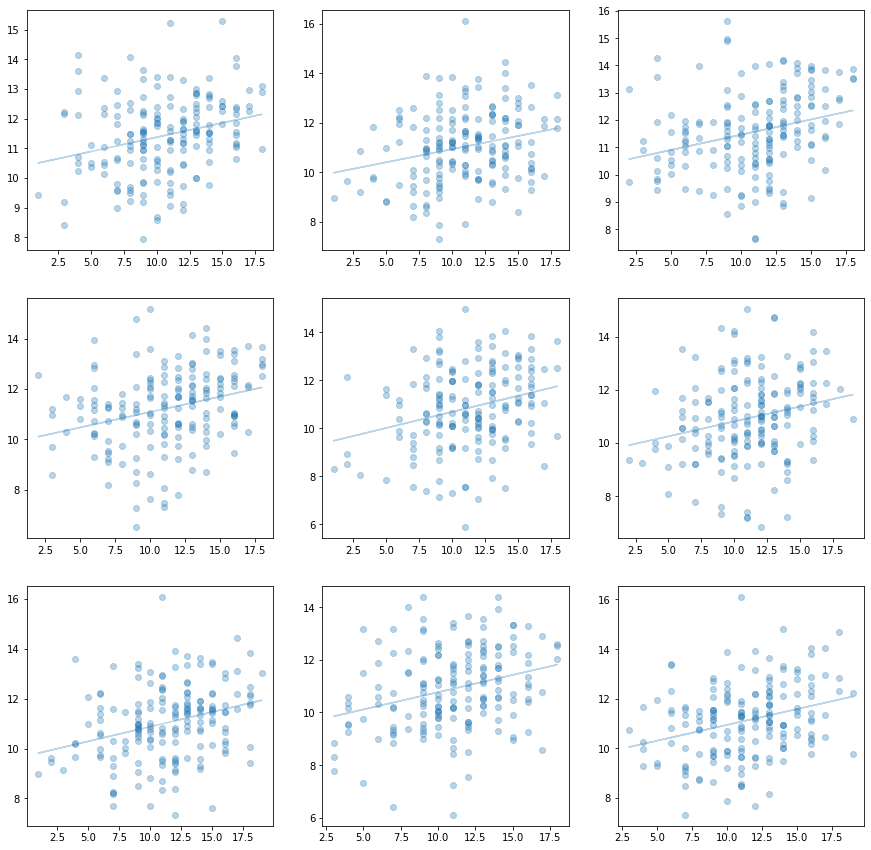

In [113]:
train_scores = []
test_scores = []
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
x_fig, y_fig = 0, 0

for i in range(0, 90):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3)
    
    pls = PLSRegression(n_components=num_component, max_iter=250)
    pls.fit(X_train, y_train)

    y_train_pred = pls.predict(X_train)
    y_test_pred = pls.predict(X_test)
    
    train_scores.append(r2_score(y_train, y_train_pred))
    test_scores.append(r2_score(y_test, y_test_pred))
    
    if (i % 10 == 0):
        axs[y_fig, x_fig].scatter(y_test, y_test_pred, alpha=0.3)
        m, b, r, p, std_err = stats.linregress(y_test, y_test_pred[:,0])
        axs[y_fig, x_fig].plot(y_test, (m * y_test) + b, alpha=0.3)
        print(x_fig, y_fig, f"r:{r:.2f}", f"r^2:{test_scores[-1]:.2f}")
        x_fig += 1
        if (x_fig % 3 == 0):
            x_fig = 0
            y_fig += 1

avg_train_score = np.mean(train_scores)
avg_test_score = np.mean(test_scores)

print("Train r^2:", avg_train_score)
print("Test r^2:", avg_test_score)
plt.show()

In [35]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

lin_reg_train = LinearRegression().fit(y_train, y_train_pred)
y_train_pred_lin_reg = lin_reg_train.predict(y_train)

lin_reg_test = LinearRegression().fit(y_test, y_test_pred)
y_test_pred_lin_reg = lin_reg_test.predict(y_test)

lin_reg_train_score = lin_reg_train.score(y_train, y_train_pred)
lin_reg_test_score = lin_reg_test.score(y_test, y_test_pred)
print("Train r^2:", lin_reg_train_score)
print("Test r^2:", lin_reg_test_score)

Train r^2: 0.7375329344836576
Test r^2: 0.39402610638250146


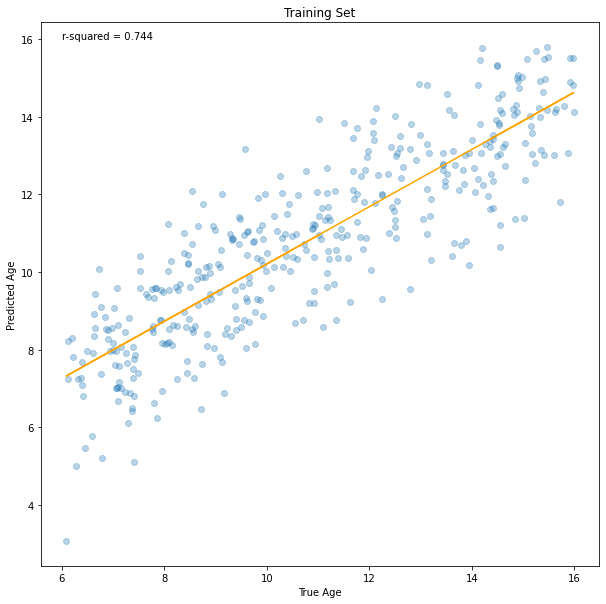

In [38]:
plt.figure(1, figsize=(10, 10))
plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.plot(y_train, y_train_pred_lin_reg, color='orange')
plt.title("Training Set")
plt.xlabel(f'True {measure_text}')
plt.ylabel(f'Predicted {measure_text}')
plt.annotate(f"r-squared = {avg_train_score:.3f}", (6, 16))
plt.show()

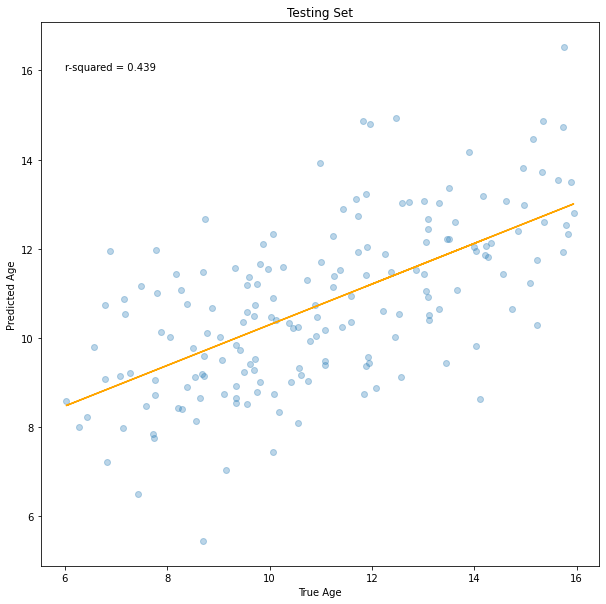

In [39]:
plt.figure(1, figsize=(10, 10))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.plot(y_test, y_test_pred_lin_reg, color='orange')
plt.title("Testing Set")
plt.xlabel(f'True {measure_text}')
plt.ylabel(f'Predicted {measure_text}')
plt.annotate(f"r-squared = {avg_test_score:.3f}", (6, 16))
plt.show()

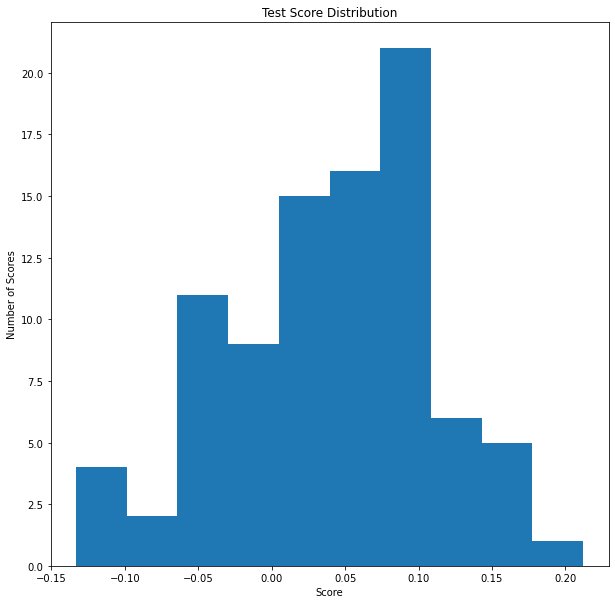

In [55]:
plt.figure(1, figsize=(10, 10))
plt.hist(x=test_scores)
plt.title("Test Score Distribution")
plt.xlabel('Score')
plt.ylabel('Number of Scores')
plt.show()